<a target="_blank" href="https://colab.research.google.com/github/ashkan-mokarian/d2l-pytorch/blob/main/chapter_transformer/4_ViT.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
%pip install d2l==1.0.0a0

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

# Patch Embedding
Conv2d is used

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (tuple, list)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size, stride=patch_size)

    def forward(self, X):
        return self.conv(X).flatten(2).transpose(1, 2)

batch_size, img_size, patch_size, num_hiddens = 2, 96, 16, 512
patch_emb = PatchEmbedding()
X = torch.ones((batch_size, 3, img_size, img_size))
d2l.check_shape(patch_emb(X), (batch_size, (img_size // patch_size)**2, num_hiddens))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# MLP layer in ViT

In [4]:
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, X):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(self.dense1(X)))))

# transformer block in ViT

In [5]:
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens, num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)
        self.ln2 = nn.LayerNorm(norm_shape)

    def forward(self, X, valid_lens=None):
        X = X + self.attention(*([self.ln1(X)] * 3), valid_lens)
        return X + self.mlp(self.ln2(X))

# Test
X = torch.ones((2, 100, 24))
vit_blk = ViTBlock(24, 24, 48, 8, 0.5)
vit_blk.eval()
d2l.check_shape(vit_blk(X), X.shape)

# All together

In [6]:
class ViT(d2l.Classifier):
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = 1 + self.patch_embedding.num_patches
        self.pos_embedding = nn.Parameter(torch.randn((1, num_steps, num_hiddens)))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(
                num_hiddens, num_hiddens, mlp_num_hiddens, num_heads, blk_dropout,
                use_bias))
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens),
                                  nn.LazyLinear(num_classes))
    
    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), dim=1)
        X = self.dropout(X + self.pos_embedding)
        for i, blk in enumerate(self.blks):
            X = blk(X)
        return self.head(X)[:, 0]

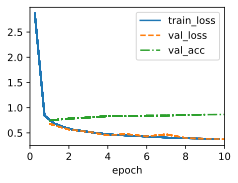

In [7]:
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
trainer.fit(model, data)